<a href="https://colab.research.google.com/github/SreeKumara/STML/blob/main/STML_LAB_PROJECT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, roc_curve, roc_auc_score,
    mean_squared_error as mse
)
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from scipy import stats

In [6]:
# Load the dataset
file_path = '/content/insurance.csv'
data = pd.read_csv(file_path)

In [7]:
# Preprocessing
# One-hot encode categorical features
data_encoded = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)


In [8]:
# Define features and target
X = data_encoded.drop(columns=['expenses'])
y = data_encoded['expenses']

In [9]:
# Take a sample subset of the data (e.g., 500 rows)
sample_data = data.sample(n=500, random_state=42)
X_sample = sample_data.drop(columns=['expenses'])
y_sample = sample_data['expenses']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)


In [10]:
# Normalize numerical features (age, bmi, children)
scaler = StandardScaler()
X_train[['age', 'bmi', 'children']] = scaler.fit_transform(X_train[['age', 'bmi', 'children']])
X_test[['age', 'bmi', 'children']] = scaler.transform(X_test[['age', 'bmi', 'children']])


In [11]:
# Function to train and evaluate models
from sklearn.metrics import root_mean_squared_error

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'RMSE': root_mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

In [12]:
# Function to calculate confidence intervals for predictions
def calculate_confidence_intervals(model, X_train, y_train, X_test, y_test, alpha=0.05):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    residuals = y_test - predictions
    mse = np.mean(residuals**2)
    se = np.sqrt(mse / len(y_test))  # Standard error of the predictions

    # Calculate confidence intervals
    margin_of_error = se * stats.t.ppf(1 - alpha / 2, df=len(y_test) - 1)
    lower_bound = predictions - margin_of_error
    upper_bound = predictions + margin_of_error
    return lower_bound, upper_bound


In [13]:
# Function for prediction intervals using bootstrapping
def prediction_interval(model, X_train, y_train, X_test, alpha=0.05, n_bootstrap=1000):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Resampling the training data for bootstrapping
    bootstrap_predictions = []
    for _ in range(n_bootstrap):
        X_resampled, y_resampled = resample(X_train, y_train)
        model.fit(X_resampled, y_resampled)
        bootstrap_predictions.append(model.predict(X_test))

    # Convert to numpy array for easier manipulation
    bootstrap_predictions = np.array(bootstrap_predictions)

    # Calculate lower and upper percentiles for prediction intervals
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)

    return lower_bound, upper_bound

In [14]:
# Learning curve plot
def plot_learning_curve(model, X_train, y_train):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)

    # Calculate mean and standard deviation for plotting
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
    plt.plot(train_sizes, test_mean, label='Cross-validation Score', color='green')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)
    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plt.title(f'Learning Curve for {model.__class__.__name__}')
    plt.legend()
    plt.grid()
    plt.show()


In [15]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'SVR': SVR(kernel='rbf')
}

In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming X_train is a pandas DataFrame
# Identify columns with 'object' dtype, which usually indicates string values
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Create a LabelEncoder for each categorical column
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    # Fit and transform the column using the encoder
    X_train[col] = encoders[col].fit_transform(X_train[col])

# Now, repeat the same process for X_test to ensure consistency
for col in categorical_cols:
    # Use the same encoder fitted on the training data
    X_test[col] = encoders[col].transform(X_test[col])

In [17]:
# Train and evaluate models
results = {name: evaluate_model(model, X_train, y_train, X_test, y_test) for name, model in models.items()}


In [18]:
# Display Regression Results
print("\nRegression Results:")
for model, metrics in results.items():
    print(f"{model}: RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}, R2={metrics['R2']:.2f}")



Regression Results:
Linear Regression: RMSE=5483.36, MAE=3773.69, R2=0.77
KNN: RMSE=8380.11, MAE=4824.63, R2=0.46
Decision Tree: RMSE=7299.09, MAE=3688.07, R2=0.59
Random Forest: RMSE=4147.86, MAE=2488.25, R2=0.87
SVR: RMSE=11965.27, MAE=7864.54, R2=-0.10


In [19]:
# Classification task for binary classification based on median
median_expenses = y_train.median()
y_train_class = (y_train > median_expenses).astype(int)
y_test_class = (y_test > median_expenses).astype(int)


In [20]:
# Train classifiers for binary classification
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(X_train, y_train_class)


RandomForestClassifier(random_state=42)

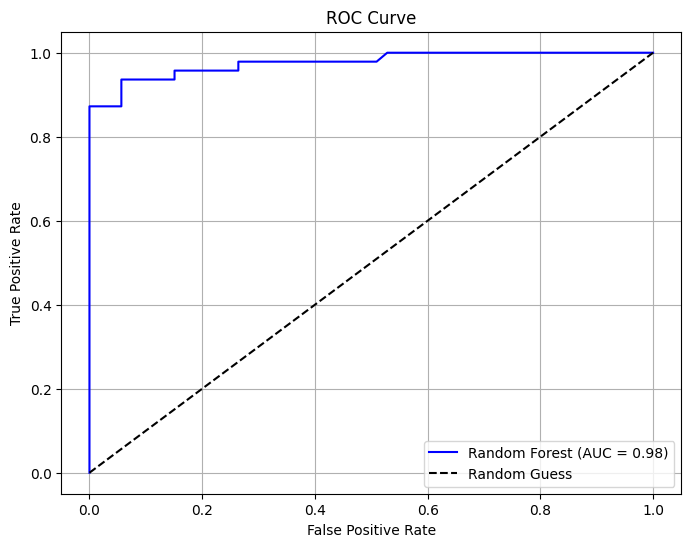

In [21]:
# Predict probabilities for ROC curve
y_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_class, y_proba_rf)
auc_score = roc_auc_score(y_test_class, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [22]:
# Classification metrics for other models
classification_results = {}


In [23]:
# Loop through models to calculate classification metrics
for name, model in models.items():
    # Predict using the regression models
    y_pred = model.predict(X_test)
    y_pred_class = (y_pred > median_expenses).astype(int)

    # Compute accuracy and F1 score
    accuracy = accuracy_score(y_test_class, y_pred_class)
    f1 = f1_score(y_test_class, y_pred_class)

    classification_results[name] = {
        'Accuracy': accuracy,
        'F1 Score': f1
    }


In [24]:
# Display classification results
print("\nClassification Metrics:")
for name, metrics in classification_results.items():
    print(f"{name}: Accuracy={metrics['Accuracy']:.2f}, F1 Score={metrics['F1 Score']:.2f}")



Classification Metrics:
Linear Regression: Accuracy=0.87, F1 Score=0.87
KNN: Accuracy=0.84, F1 Score=0.84
Decision Tree: Accuracy=0.87, F1 Score=0.87
Random Forest: Accuracy=0.88, F1 Score=0.88
SVR: Accuracy=0.83, F1 Score=0.78


In [25]:
# Visualizations

<ipython-input-26-0432361f7b60>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_indices], y=features[sorted_indices], palette='viridis')


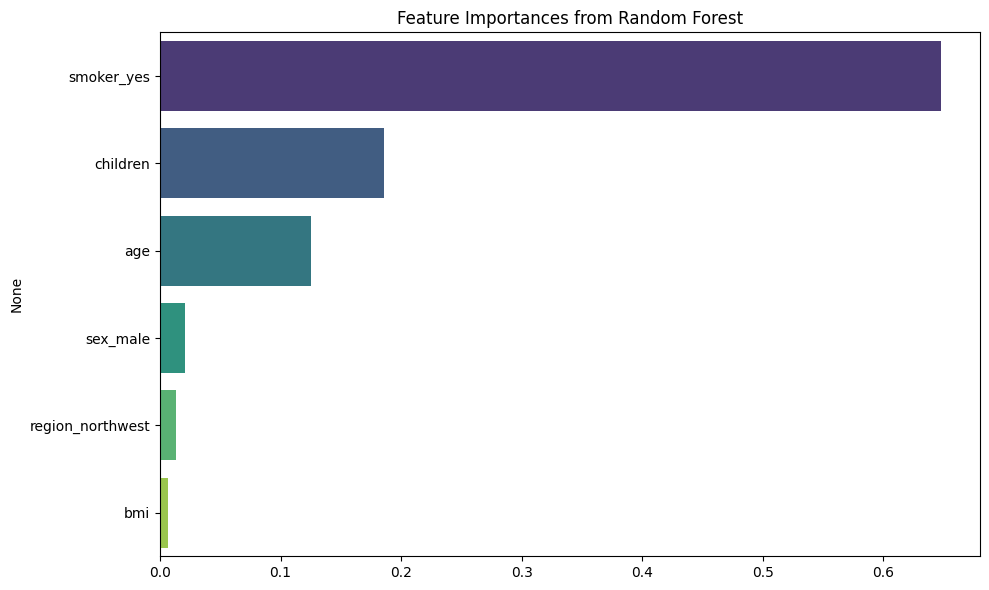

In [26]:

# Feature Importances
feature_importances = models['Random Forest'].feature_importances_
features = X.columns
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_indices], y=features[sorted_indices], palette='viridis')
plt.title('Feature Importances from Random Forest')
plt.tight_layout()
plt.show()

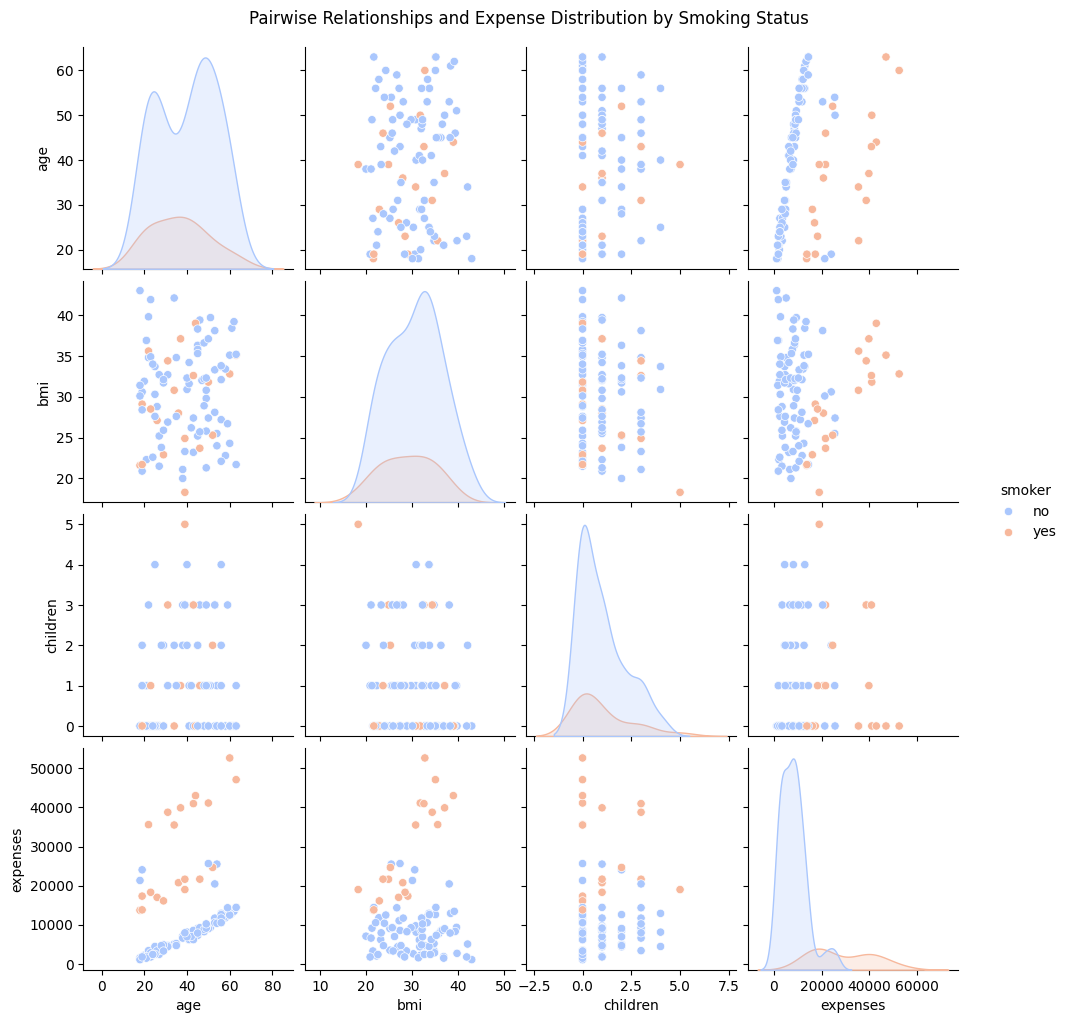

In [27]:
# Pairplot for numerical features and expenses
sns.pairplot(data.sample(100), vars=['age', 'bmi', 'children', 'expenses'], diag_kind='kde', hue='smoker', palette='coolwarm')
plt.suptitle('Pairwise Relationships and Expense Distribution by Smoking Status', y=1.02)
plt.show()

<ipython-input-28-3efeb2fb687b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='region', y='expenses', palette='coolwarm')


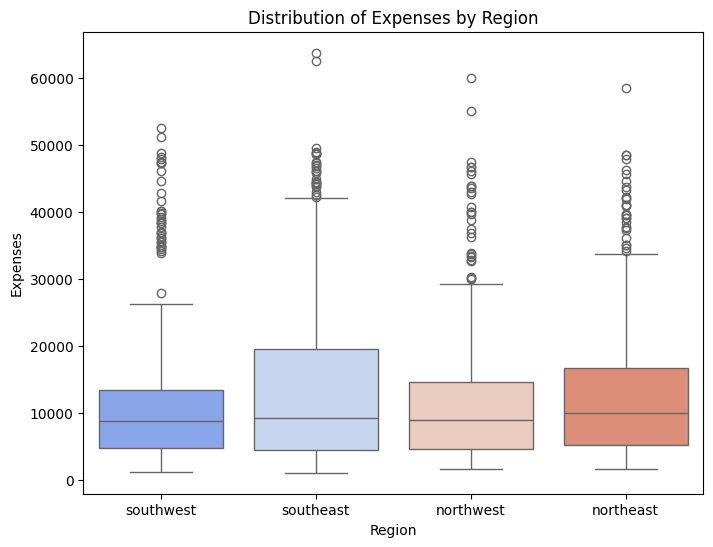

In [28]:
# Boxplot: Expenses vs. Region
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='region', y='expenses', palette='coolwarm')
plt.title('Distribution of Expenses by Region')
plt.xlabel('Region')
plt.ylabel('Expenses')
plt.show()

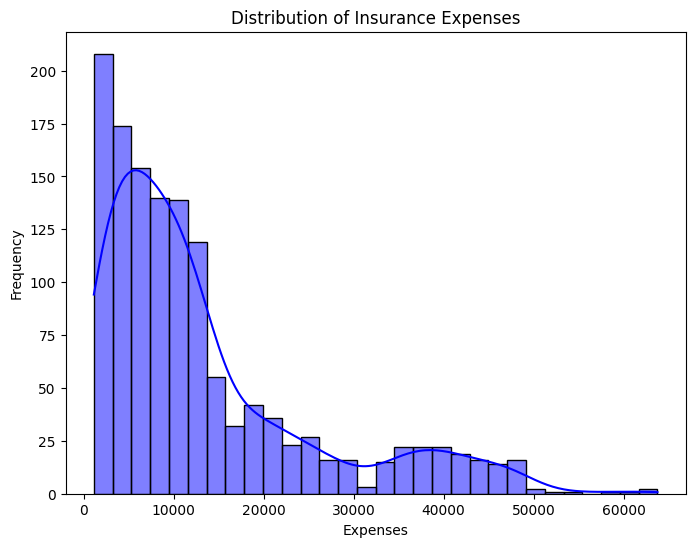

In [29]:
# Distribution plot: Expenses
plt.figure(figsize=(8, 6))
sns.histplot(data['expenses'], kde=True, color='blue', bins=30)
plt.title('Distribution of Insurance Expenses')
plt.xlabel('Expenses')
plt.ylabel('Frequency')
plt.show()

In [30]:
def plot_svm_regression(model, X_test, y_test):
  """Plots the SVM regression results."""

  # Get the predictions
  y_pred = model.predict(X_test)

  # Create a scatter plot of the actual vs. predicted values
  plt.figure(figsize=(8, 6))
  plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
  plt.xlabel('Actual Expenses')
  plt.ylabel('Predicted Expenses')
  plt.title('SVM Regression: Actual vs. Predicted')
  plt.grid(True)
  plt.show()

  # If data has only two features, plot the decision boundary
  if X_test.shape[1] == 2:
      # Create a meshgrid for plotting the decision boundary
      x_min, x_max = X_test.iloc[:, 0].min() - 1, X_test.iloc[:, 0].max() + 1
      y_min, y_max = X_test.iloc[:, 1].min() - 1, X_test.iloc[:, 1].max() + 1
      xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                          np.arange(y_min, y_max, 0.1))

      # Get predictions for the meshgrid points
      Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
      Z = Z.reshape(xx.shape)

      # Plot the decision boundary
      plt.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
      plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, cmap='viridis', edgecolors='k')
      plt.xlabel('Feature 1')
      plt.ylabel('Feature 2')
      plt.title('SVM Regression Decision Boundary')
      plt.show()
  else:
      print("Decision boundary plotting is only available for 2-dimensional data.")

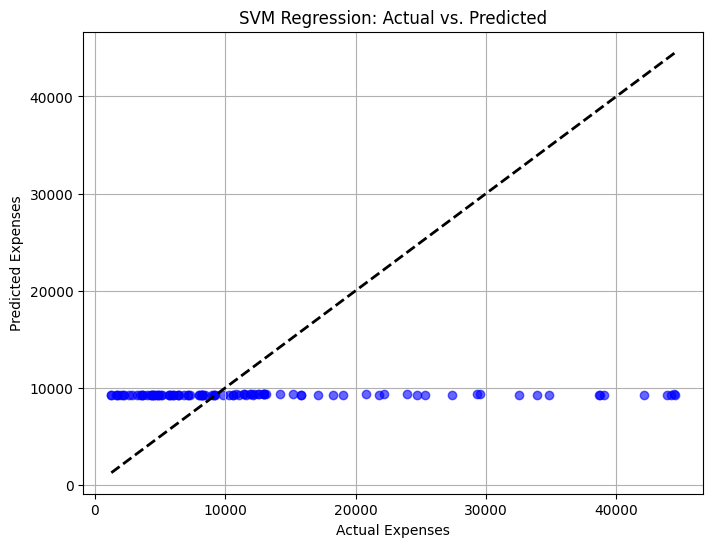

Decision boundary plotting is only available for 2-dimensional data.


In [31]:
plot_svm_regression(models['SVR'], X_test, y_test)

In [34]:
# Calculate correlation for numerical features only by specifying numeric_only=True
correlation_matrix = data.corr(numeric_only=True)

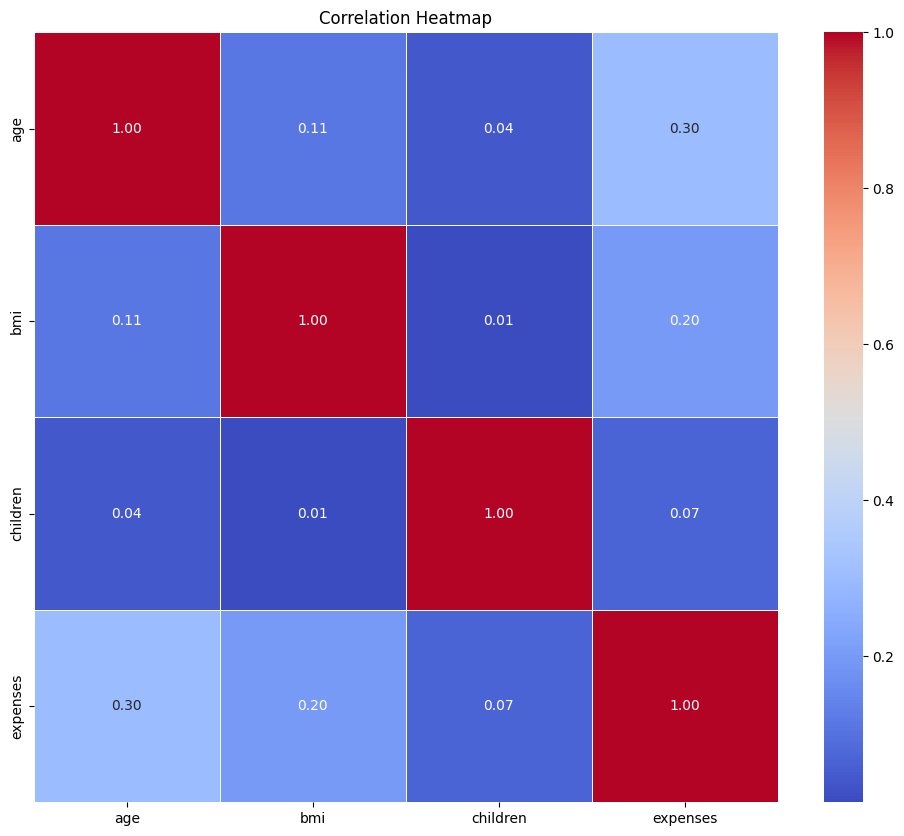

In [35]:
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


Evaluating Linear Regression:
Confidence Interval for Predictions: Lower Bound: [32245.20882581  7442.10650422 -1351.50477923  6671.76960268
 10363.37322063], Upper Bound: [34421.24274449  9618.1404229    824.52913945  8847.80352136
 12539.40713932]


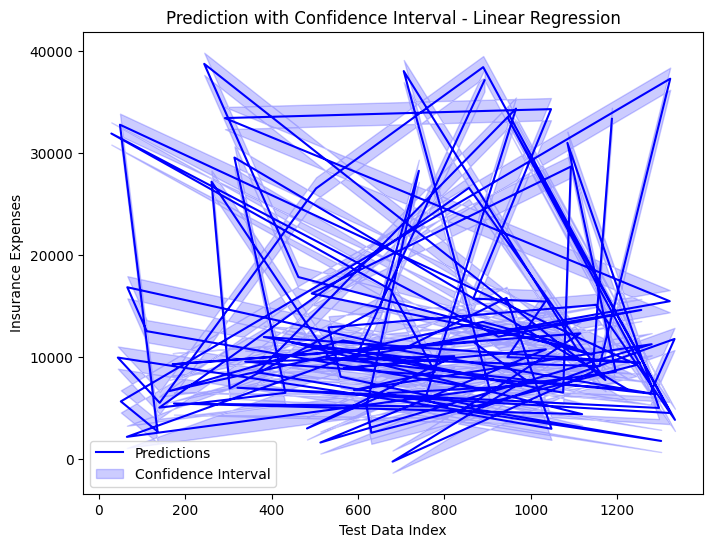

Prediction Interval: Lower Bound: [31135.14433421  7636.36533762 -2001.37702921  6518.11523086
  9632.1478847 ], Upper Bound: [35926.34512603  9538.00487627  1548.01525719  9077.73687682
 13261.62423735]


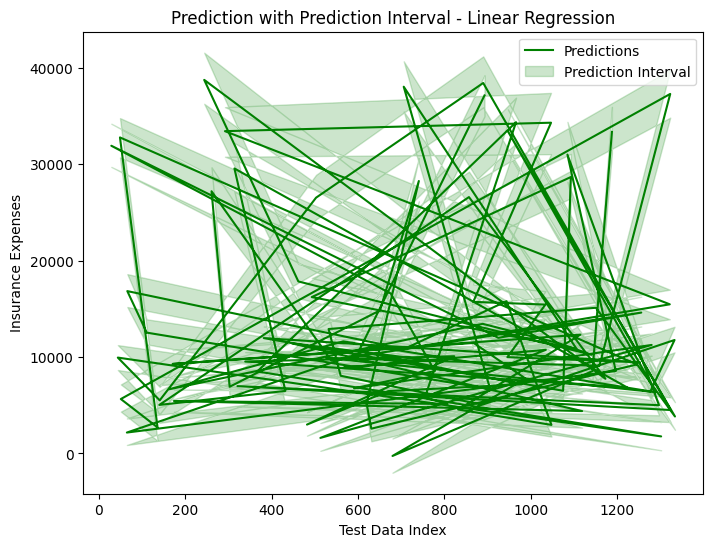

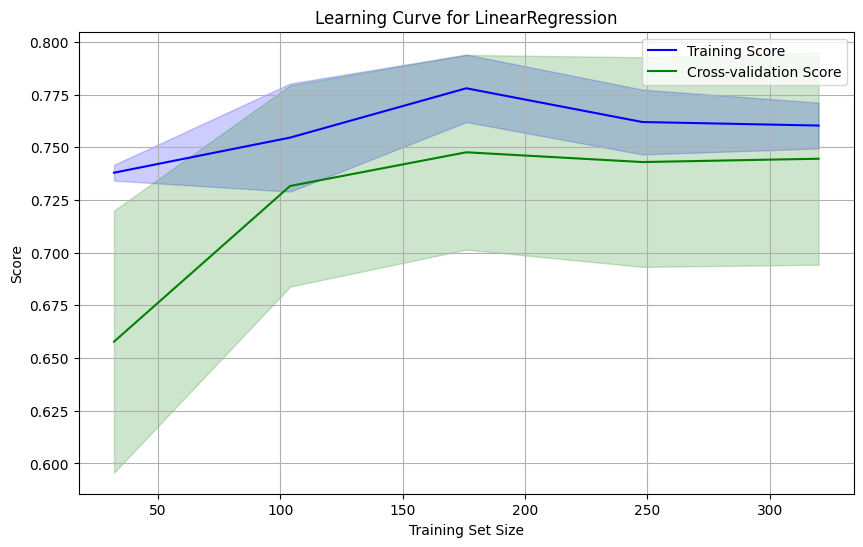


Evaluating KNN:
Confidence Interval for Predictions: Lower Bound: [26708.36709413  7430.31509413   826.49309413  4196.68909413
 13042.41709413], Upper Bound: [30033.95690587 10755.90490587  4152.08290587  7522.27890587
 16368.00690587]


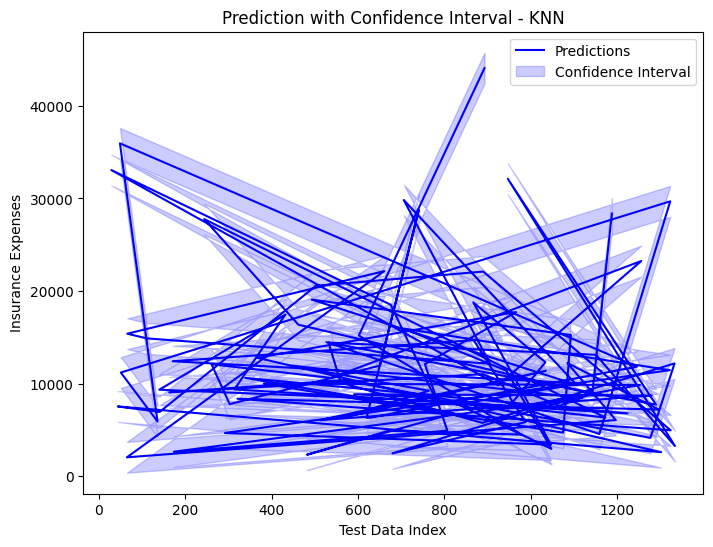

Prediction Interval: Lower Bound: [17065.85355  5294.9764   1871.54     3503.484    9729.296  ], Upper Bound: [34767.2748  14376.262    3254.6826  10500.44445 22968.1945 ]


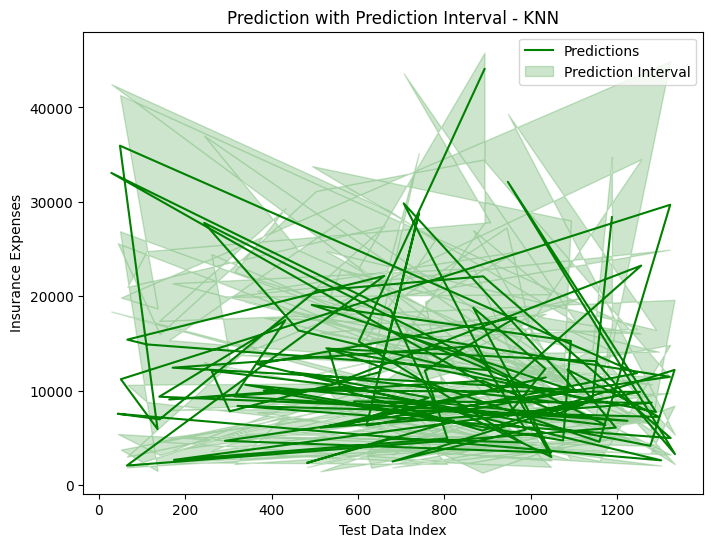

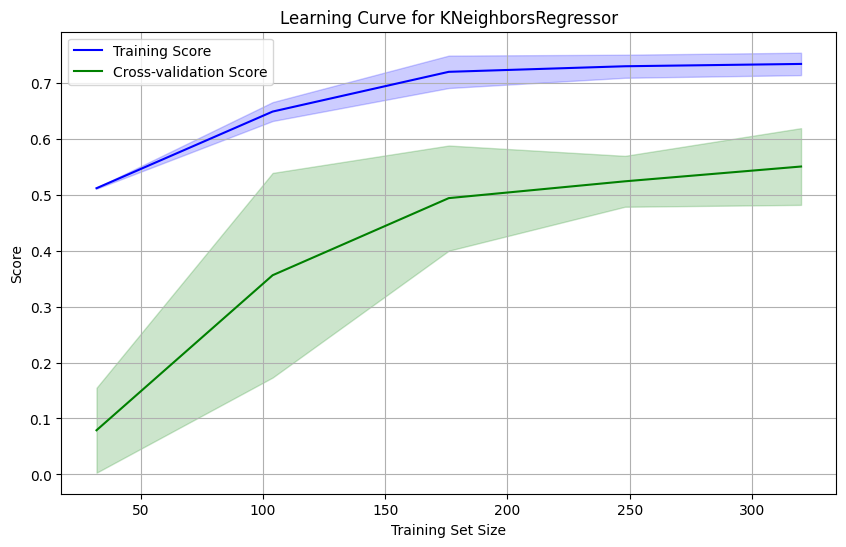


Evaluating Decision Tree:
Confidence Interval for Predictions: Lower Bound: [21953.01252  4634.11252  1149.48252 10956.58252 28811.70252], Upper Bound: [24849.60748  7530.70748  4046.07748 13853.17748 31708.29748]


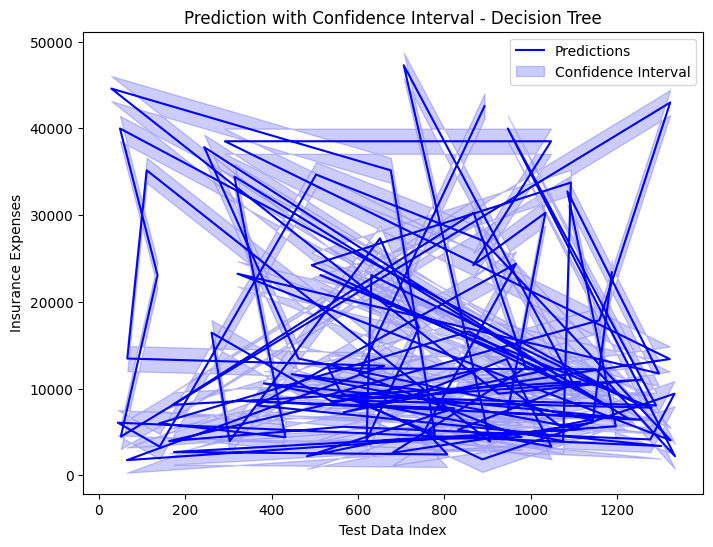

Prediction Interval: Lower Bound: [19515.54  5124.19  1731.68  4399.73 11830.61], Upper Bound: [37829.72 14358.36  3378.91 14358.36 30260.  ]


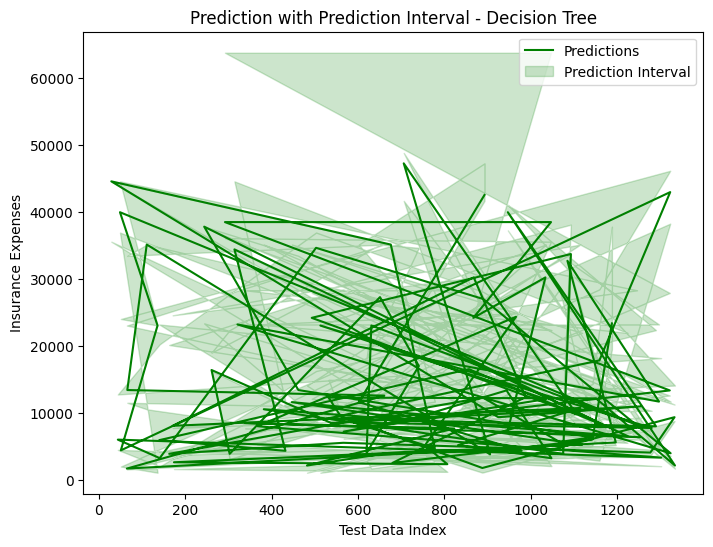

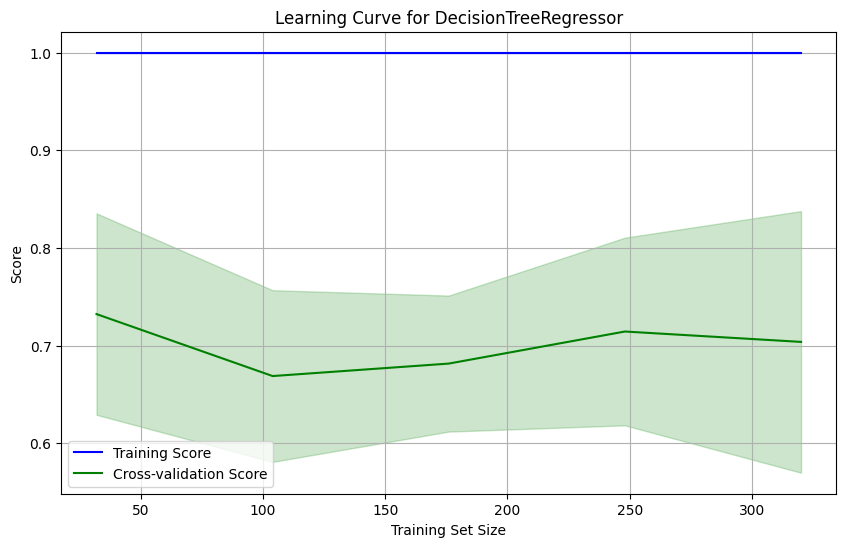


Evaluating Random Forest:
Confidence Interval for Predictions: Lower Bound: [21609.69584715  5859.29434715  1672.27834715  8580.08584715
 18577.91294715], Upper Bound: [23255.74475285  7505.34325285  3318.32725285 10226.13475285
 20223.96185285]


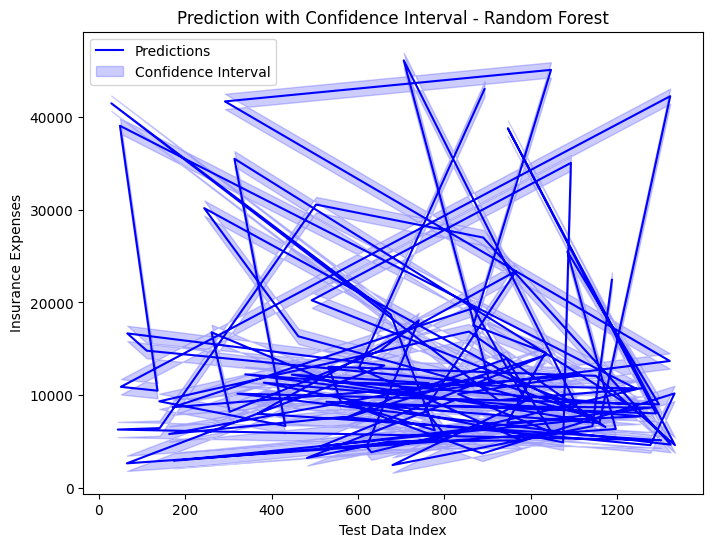

Prediction Interval: Lower Bound: [20551.42575    6223.707655   2081.2846275  5000.8808075 12843.6421425], Upper Bound: [26414.5225025  7950.19473    3631.428475  11769.9958425 26113.29581  ]


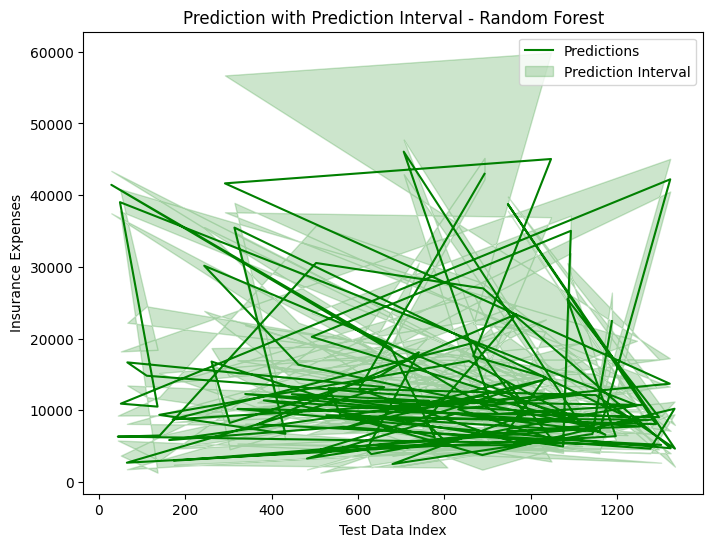

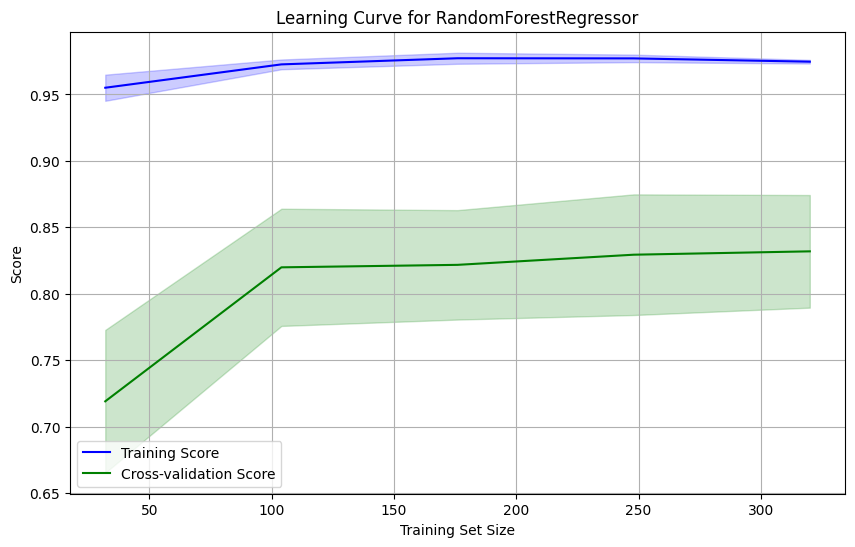


Evaluating SVR:
Confidence Interval for Predictions: Lower Bound: [6930.80863752 6911.39177806 6901.95271012 6907.8575315  6942.84077444], Upper Bound: [11679.14868061 11659.73182115 11650.29275321 11656.19757459
 11691.18081753]


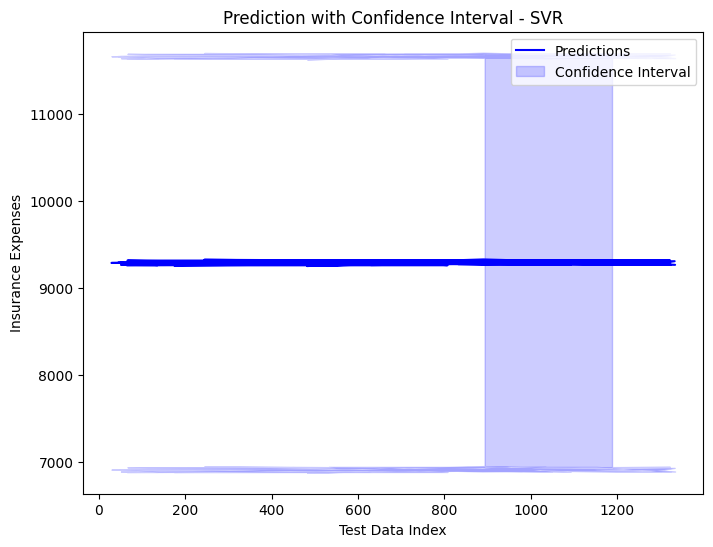

Prediction Interval: Lower Bound: [8283.14036063 8256.58683645 8247.16431547 8257.87471083 8294.38016802], Upper Bound: [10078.65637884 10060.11326048 10053.85020902 10052.93703805
 10089.29530863]


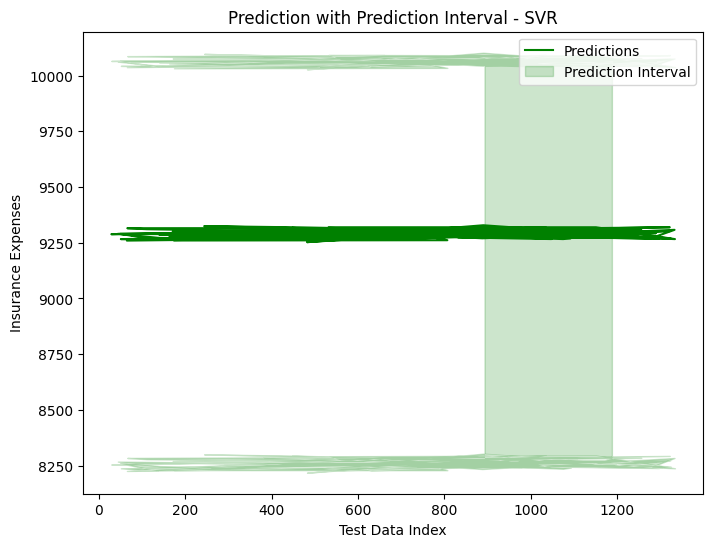

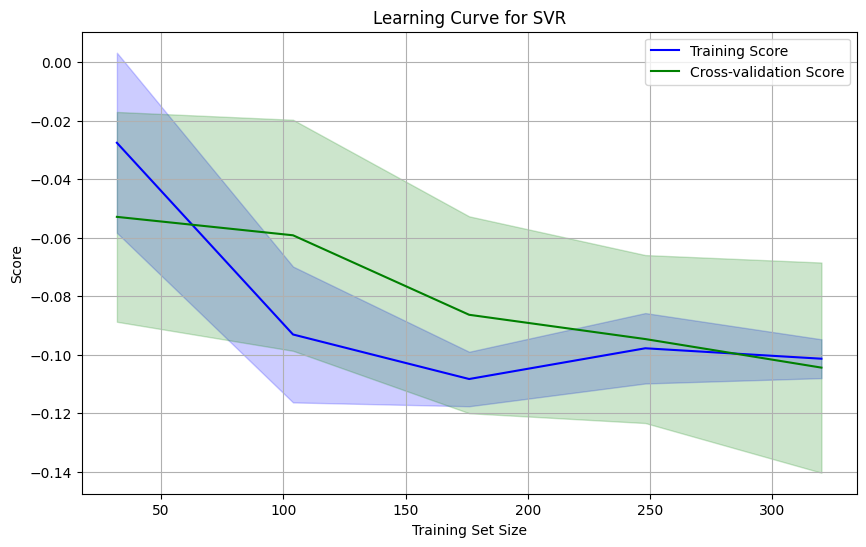

In [32]:
# Confidence Intervals and Prediction Intervals for each model
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}:")

    # Fit model and predict
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Confidence Intervals
    lower_ci, upper_ci = calculate_confidence_intervals(model, X_train, y_train, X_test, y_test)
    print(f"Confidence Interval for Predictions: Lower Bound: {lower_ci[:5]}, Upper Bound: {upper_ci[:5]}")

    # Plot Confidence Interval visualization
    plt.figure(figsize=(8, 6))
    plt.plot(y_test.index, predictions, label='Predictions', color='blue')
    plt.fill_between(y_test.index, lower_ci, upper_ci, color='blue', alpha=0.2, label='Confidence Interval')
    plt.title(f"Prediction with Confidence Interval - {model_name}")
    plt.xlabel('Test Data Index')
    plt.ylabel('Insurance Expenses')
    plt.legend()
    plt.show()

    # Prediction Intervals
    lower_pi, upper_pi = prediction_interval(model, X_train, y_train, X_test)
    print(f"Prediction Interval: Lower Bound: {lower_pi[:5]}, Upper Bound: {upper_pi[:5]}")

    # Plot Prediction Interval visualization
    plt.figure(figsize=(8, 6))
    plt.plot(y_test.index, predictions, label='Predictions', color='green')
    plt.fill_between(y_test.index, lower_pi, upper_pi, color='green', alpha=0.2, label='Prediction Interval')
    plt.title(f"Prediction with Prediction Interval - {model_name}")
    plt.xlabel('Test Data Index')
    plt.ylabel('Insurance Expenses')
    plt.legend()
    plt.show()

    # Learning Curves
    plot_learning_curve(model, X_train, y_train)

In [36]:
# All the Related Graphs Are Below

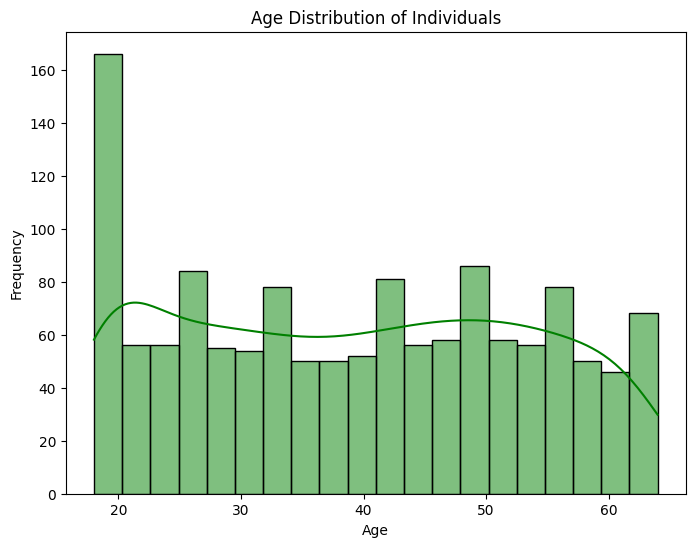

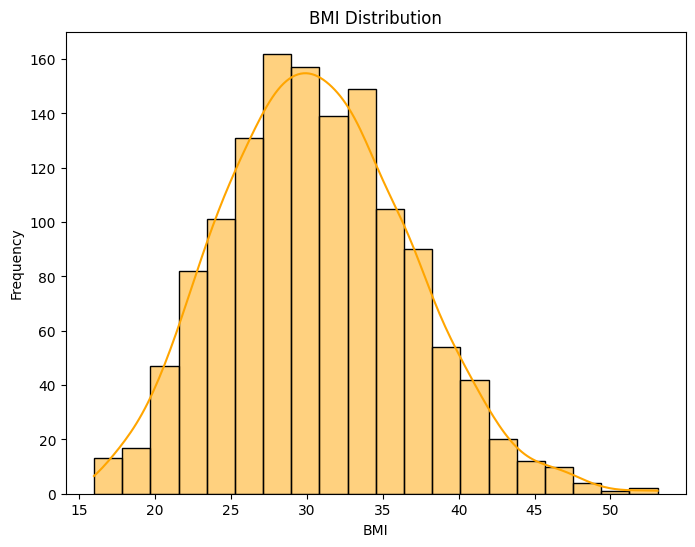

<ipython-input-37-5165d46f9dfb>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='smoker', y='expenses', palette='Set2')


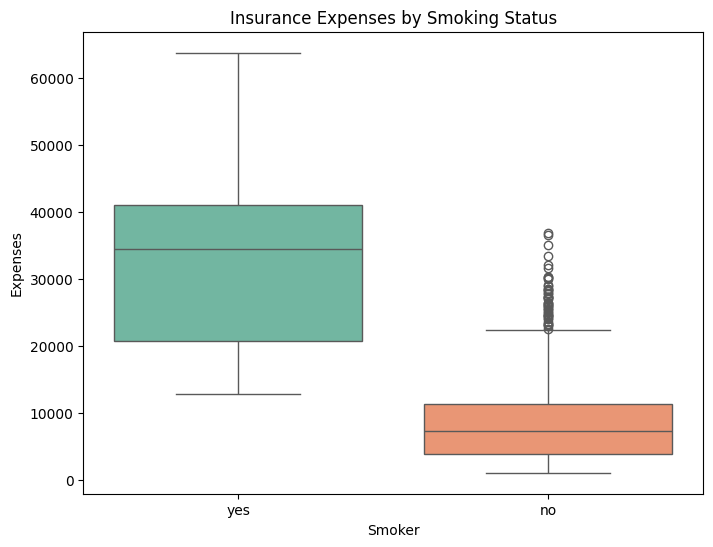

<ipython-input-37-5165d46f9dfb>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='children', palette='coolwarm')


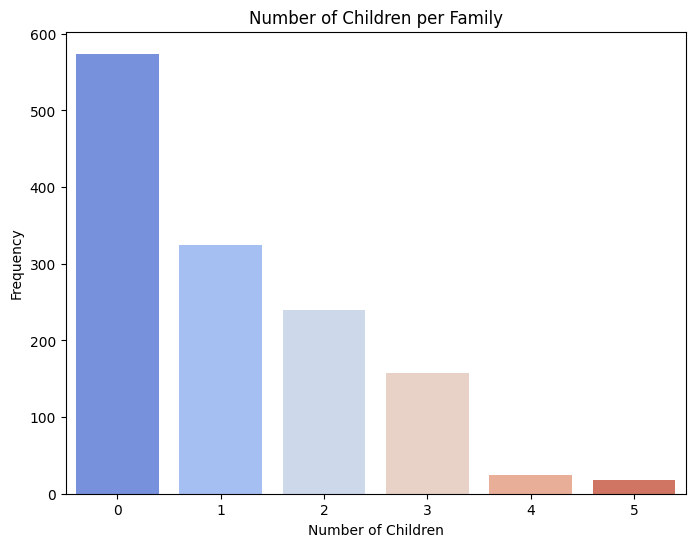

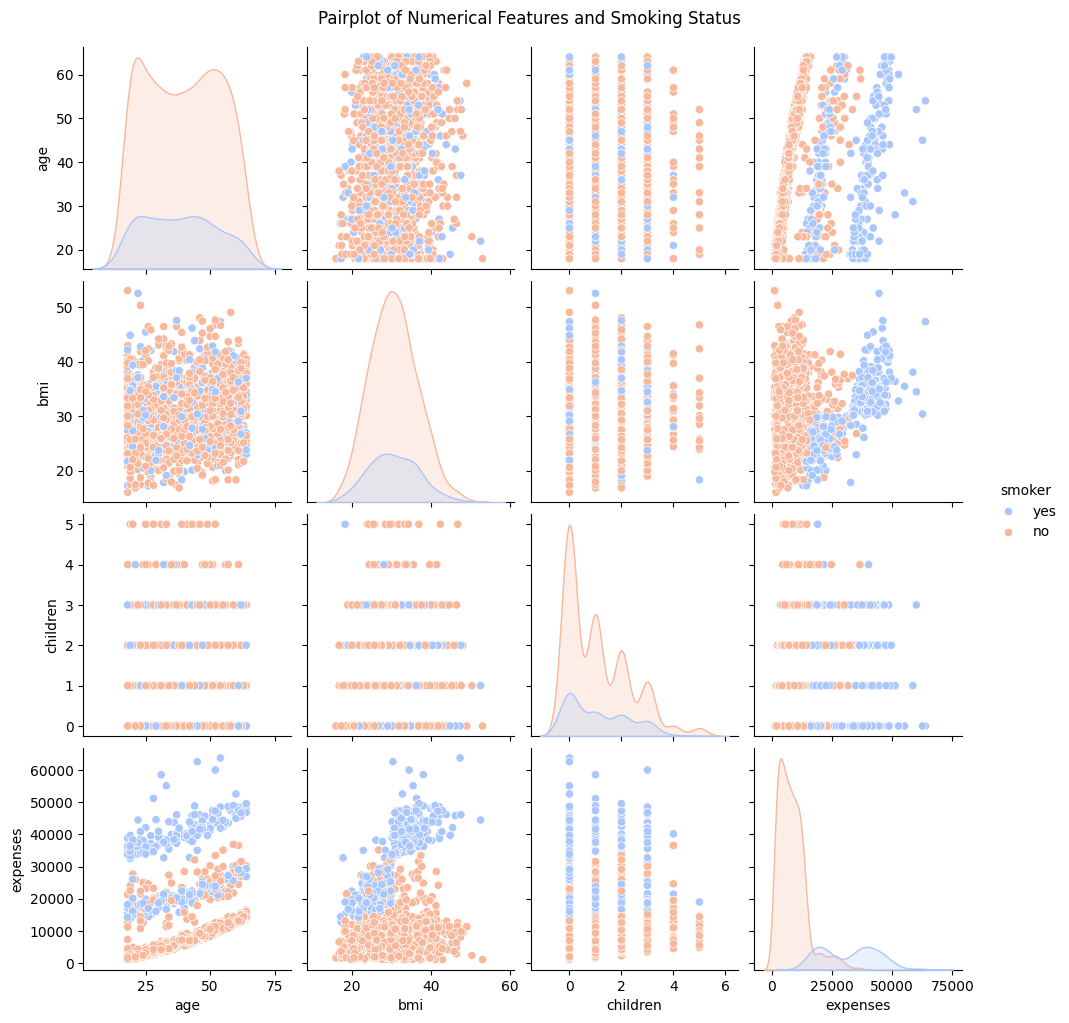

<ipython-input-37-5165d46f9dfb>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='region', y='expenses', palette='coolwarm')


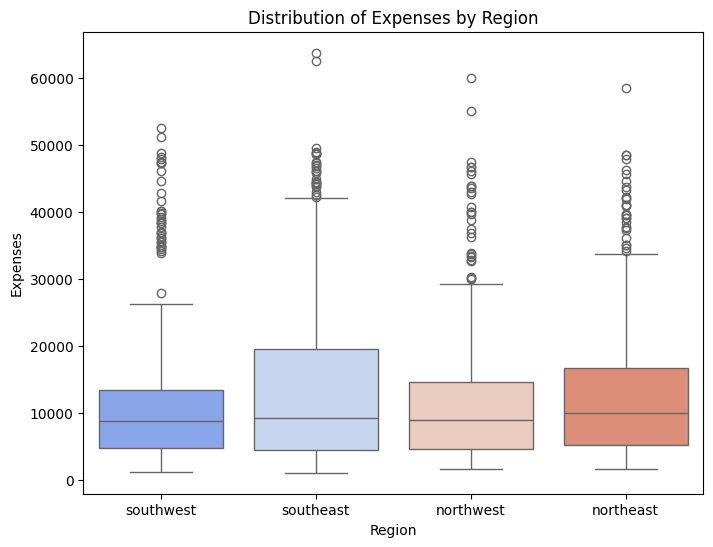

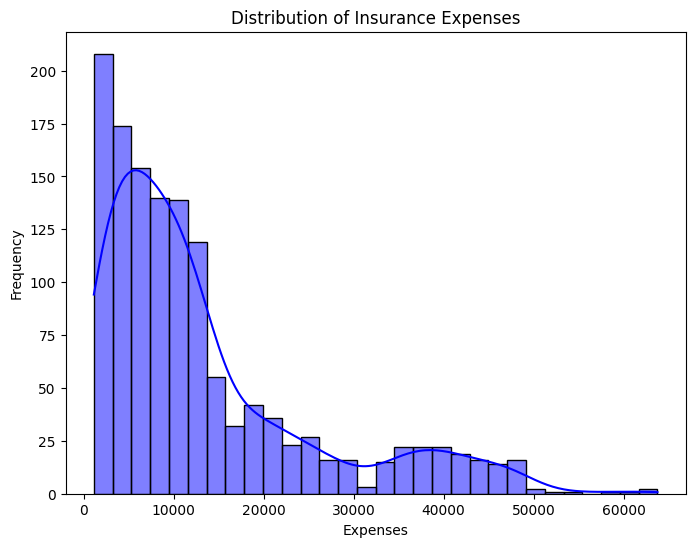

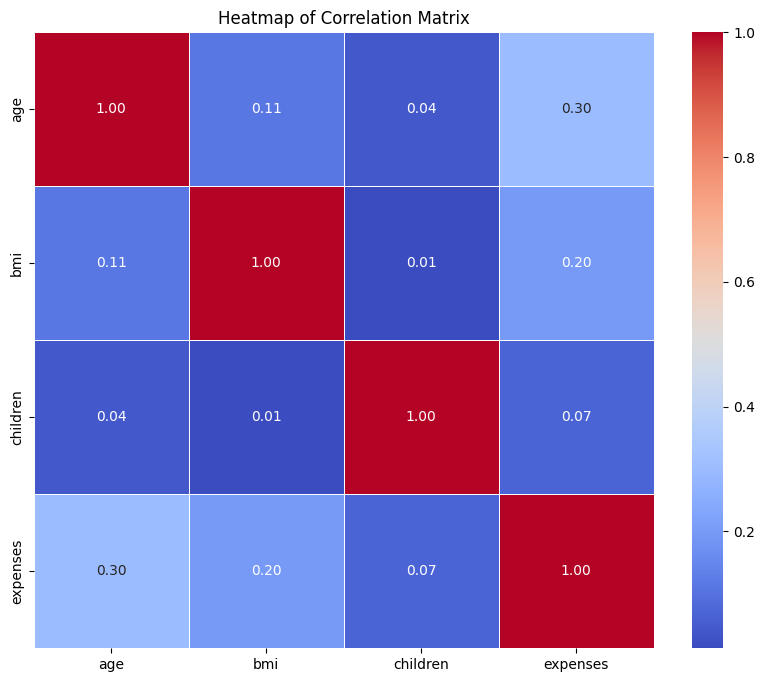

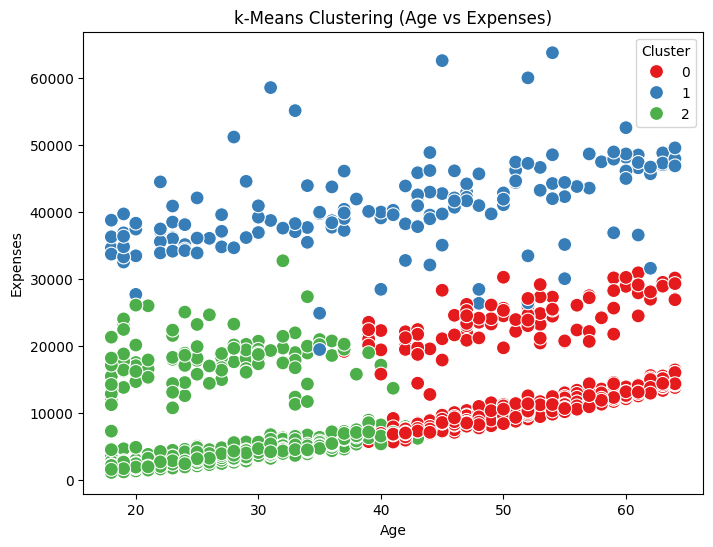

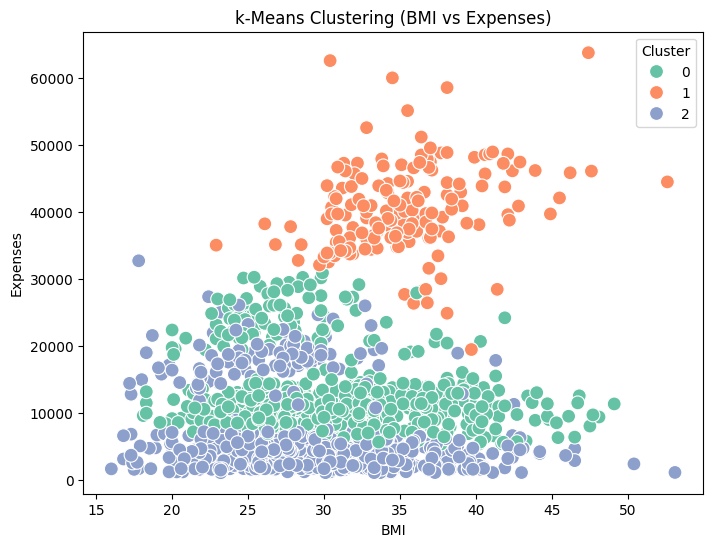

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('/content/insurance.csv')

# 1. Age Distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['age'], kde=True, color='green', bins=20)
plt.title('Age Distribution of Individuals')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# 2. BMI Distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['bmi'], kde=True, color='orange', bins=20)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

# 3. Insurance Expenses by Smoking Status
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='smoker', y='expenses', palette='Set2')
plt.title('Insurance Expenses by Smoking Status')
plt.xlabel('Smoker')
plt.ylabel('Expenses')
plt.show()

# 4. Number of Children per Family
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='children', palette='coolwarm')
plt.title('Number of Children per Family')
plt.xlabel('Number of Children')
plt.ylabel('Frequency')
plt.show()

# 5. Pairplot of Numerical Features
sns.pairplot(data, vars=['age', 'bmi', 'children', 'expenses'], diag_kind='kde', hue='smoker', palette='coolwarm')
plt.suptitle('Pairplot of Numerical Features and Smoking Status', y=1.02)
plt.show()

# 6. Expenses by Region
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='region', y='expenses', palette='coolwarm')
plt.title('Distribution of Expenses by Region')
plt.xlabel('Region')
plt.ylabel('Expenses')
plt.show()

# 7. Distribution of Insurance Expenses
plt.figure(figsize=(8, 6))
sns.histplot(data['expenses'], kde=True, color='blue', bins=30)
plt.title('Distribution of Insurance Expenses')
plt.xlabel('Expenses')
plt.ylabel('Frequency')
plt.show()

# 8. Heatmap: Correlation Matrix
plt.figure(figsize=(10, 8))
# Select only numerical features for correlation calculation
numerical_data = data.select_dtypes(include=['number'])
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

# 9. k-Means Clustering
# Selecting features for clustering
features = ['age', 'bmi', 'expenses']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

# Perform k-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Scatter plot of clusters (age vs expenses, color-coded by cluster)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='age', y='expenses', hue='Cluster', palette='Set1', s=100)
plt.title('k-Means Clustering (Age vs Expenses)')
plt.xlabel('Age')
plt.ylabel('Expenses')
plt.legend(title='Cluster')
plt.show()

# Scatter plot of clusters (BMI vs expenses, color-coded by cluster)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='bmi', y='expenses', hue='Cluster', palette='Set2', s=100)
plt.title('k-Means Clustering (BMI vs Expenses)')
plt.xlabel('BMI')
plt.ylabel('Expenses')
plt.legend(title='Cluster')
plt.show()
